In [1]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import MinMaxScaler # Data normalization
from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost

In [3]:
# pip install tensorflow==2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ipcvlab/anaconda2/e

In [4]:
df_train = pd.read_excel("/home/ipcvlab/Downloads/ilceler/yıllık-ilk-calısma/cekmekoy_tum_veriler.xlsx", index_col = 0) 
cols_list = list(df_train.columns) 

In [5]:
df_train.head()

,HouseEndex,bist,USD/TRY,Aylık_Mevduat_Faizi,Konut_Kredisi,ic_borc_maliyet,tufe_endeks,guven_endeksi
Tarih,,,,,,,,
2003-01,65.55,11032.03,1.663822,47.4880,44.0280,56.824577,94.77,NaN
2003-02,66.21,11574.44,1.631060,47.9525,43.3100,55.323955,96.23,NaN
2003-03,67.24,9475.09,1.663371,48.4425,45.8475,59.930634,98.12,NaN
2003-04,68.15,11509.95,1.635045,48.0475,50.3050,57.498830,99.09,NaN
2003-05,68.69,11381.41,1.497566,44.4780,45.3620,51.079707,100.04,NaN


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 2003-01 to 2019-12
Data columns (total 8 columns):
HouseEndex              204 non-null float64
bist                    204 non-null float64
USD/TRY                 204 non-null float64
Aylık_Mevduat_Faizi     204 non-null float64
Konut_Kredisi           204 non-null float64
ic_borc_maliyet         204 non-null float64
tufe_endeks             204 non-null float64
guven_endeksi           192 non-null float64
dtypes: float64(8)
memory usage: 14.3+ KB


In [7]:
df_train.describe()

,HouseEndex,bist,USD/TRY,Aylık_Mevduat_Faizi,Konut_Kredisi,ic_borc_maliyet,tufe_endeks,guven_endeksi
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,192.000000
mean,138.306324,60357.147696,2.286973,13.975219,16.954001,15.440405,211.077549,73.889131
std,64.795413,27993.177820,1.294062,8.225539,7.843219,9.362502,89.697329,9.657939
min,65.550000,9475.090000,1.176086,5.264000,8.297500,5.685006,94.770000,55.136536
25%,88.725000,38159.450000,1.436319,8.498000,11.836875,9.246844,138.420000,67.456996
50%,103.450000,61571.040000,1.688293,10.970000,14.162250,12.149540,188.375000,73.808016
75%,203.000000,80379.620000,2.857129,17.523750,18.941750,18.722633,264.132500,79.307277
max,251.600000,119528.790000,6.378340,48.442500,50.305000,59.930634,440.500000,98.677315


### display Missing values

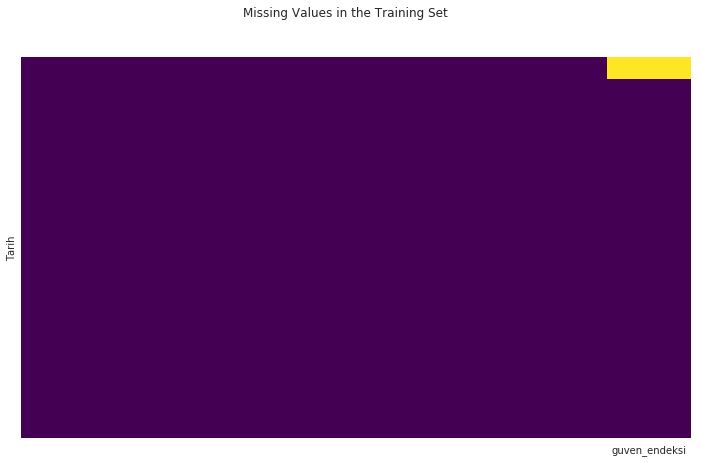

In [8]:
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [9]:
replace = True # True: replace null in guven_endeksi with average. False: guven_endeksi kullanmadan
if replace:
    df_train = df_train.fillna(df_train.mean())
else:
    df_train.drop('guven_endeksi', axis=1, inplace=True)

In [10]:
# Correlation matrix
corr_mat = df_train.corr().abs()
# Find most important features relative to target
corr_mat.sort_values(by=["HouseEndex"], ascending = False, inplace = True)
print(corr_mat.HouseEndex)

HouseEndex              1.000000
tufe_endeks             0.938245
USD/TRY                 0.896264
bist                    0.875104
guven_endeksi           0.580349
Konut_Kredisi           0.305519
ic_borc_maliyet         0.265238
Aylık_Mevduat_Faizi     0.253678
Name: HouseEndex, dtype: float64


In [11]:
#Correlation matrix between features
corr_mat = df_train.corr().abs()

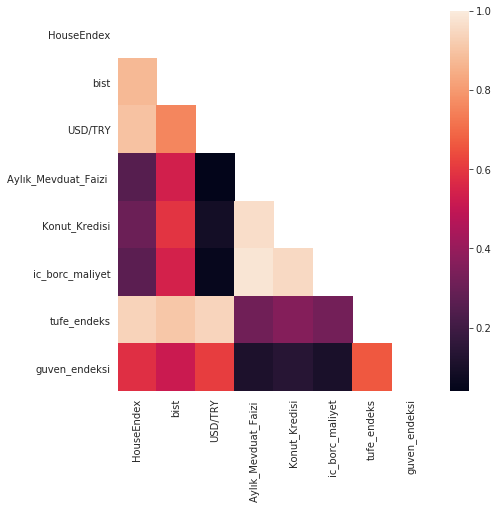

In [12]:
#Plot the heatmap with seaborn
plt.figure(figsize=(7,7)) 

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_mat, mask=mask,
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

In [13]:
#List the highly correlated columns
corr_tmp = corr_mat.unstack()
corr_tmp = corr_tmp.sort_values(kind="quicksort")

print(corr_tmp[-len(corr_mat)-10:-len(corr_mat)])

tufe_endeks           HouseEndex              0.938245
HouseEndex            tufe_endeks             0.938245
USD/TRY               tufe_endeks             0.942730
tufe_endeks           USD/TRY                 0.942730
ic_borc_maliyet       Konut_Kredisi           0.953954
Konut_Kredisi         ic_borc_maliyet         0.953954
Aylık_Mevduat_Faizi   Konut_Kredisi           0.964143
Konut_Kredisi         Aylık_Mevduat_Faizi     0.964143
ic_borc_maliyet       Aylık_Mevduat_Faizi     0.982354
Aylık_Mevduat_Faizi   ic_borc_maliyet         0.982354
dtype: float64


In [14]:
# Find most important features relative to target
corr_mat.sort_values(["HouseEndex"], ascending = False, inplace = True)
print(corr_mat.HouseEndex)

HouseEndex              1.000000
tufe_endeks             0.938245
USD/TRY                 0.896264
bist                    0.875104
guven_endeksi           0.580349
Konut_Kredisi           0.305519
ic_borc_maliyet         0.265238
Aylık_Mevduat_Faizi     0.253678
Name: HouseEndex, dtype: float64


# Skewness

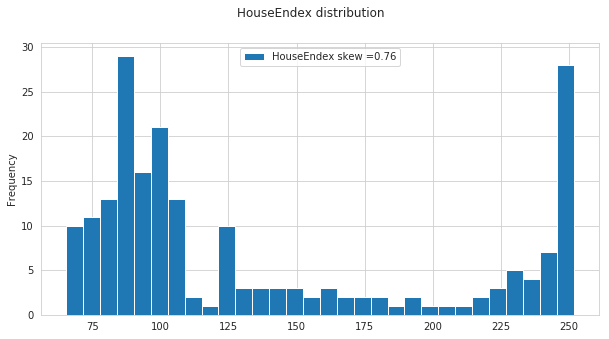

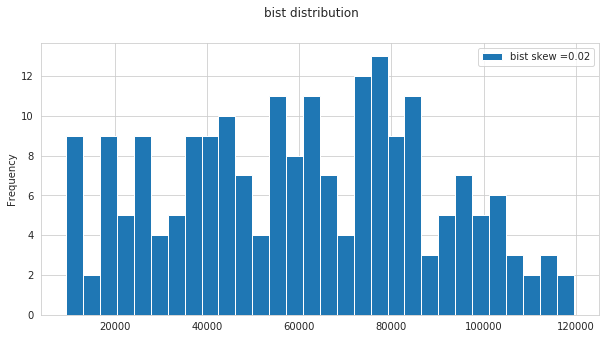

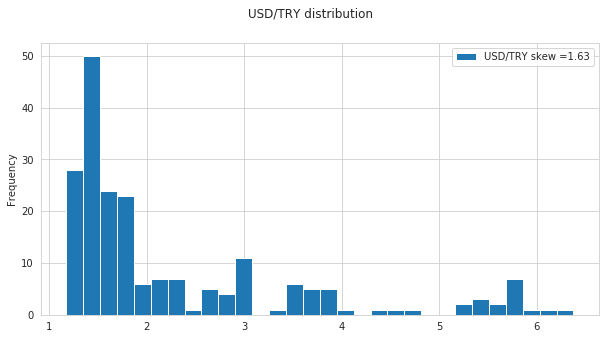

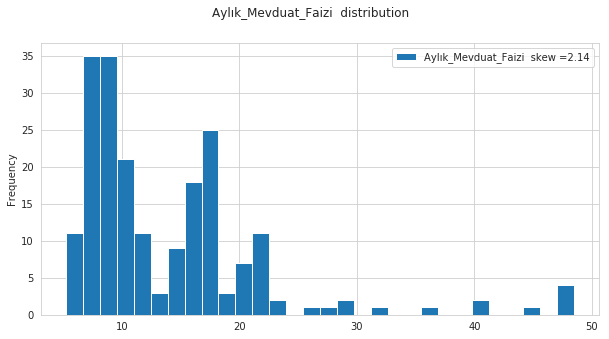

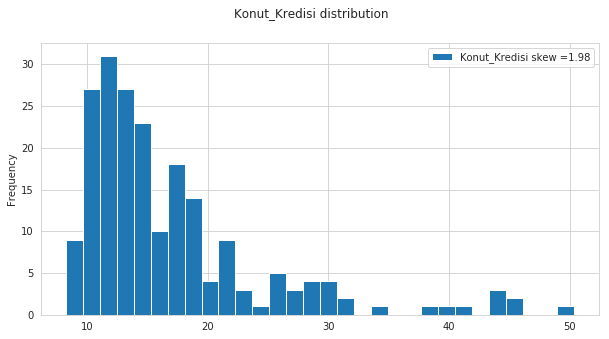

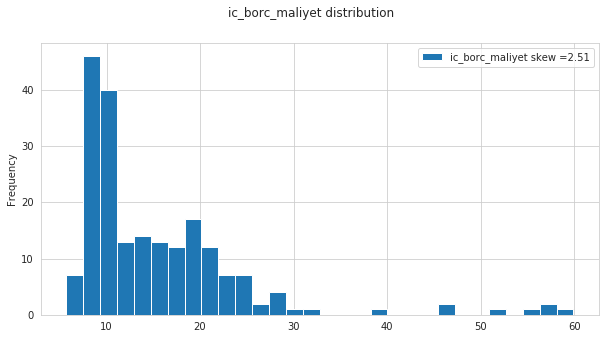

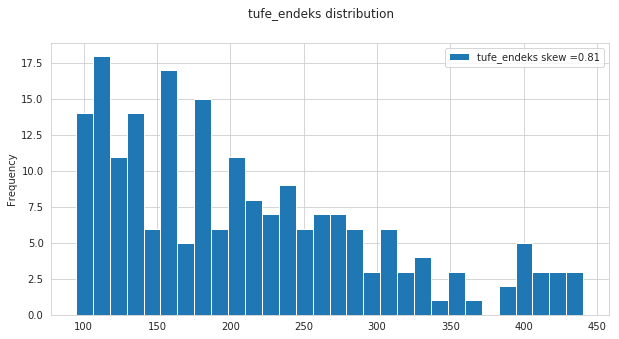

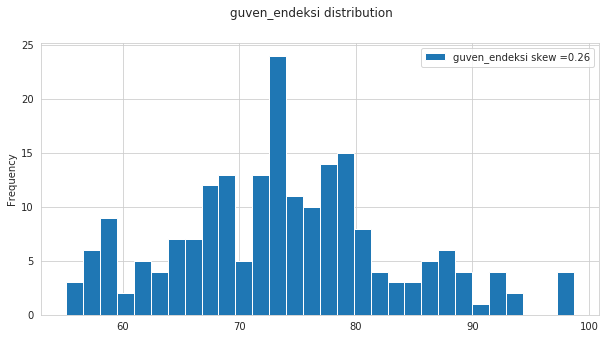

In [15]:
#Check the skewness of HouseEndeks
for col in cols_list:
    plt.figure(figsize=(10, 5))
    skewness = df_train[col].skew()
    df_train[col].plot.hist(edgecolor='white', bins=30, 
                                    label=col + ' skew =' + str(round(skewness,2)))
    plt.suptitle("{} distribution".format(col))
    plt.legend()
    plt.show()

# Box plots

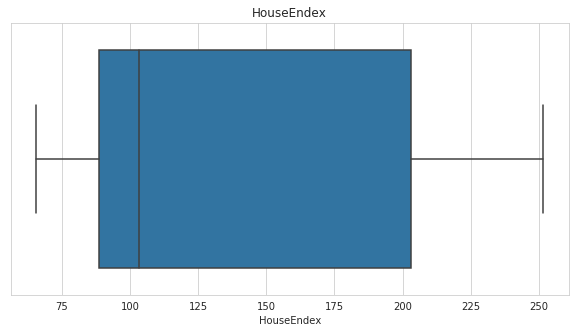

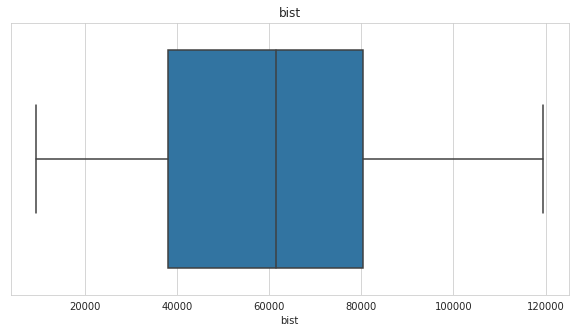

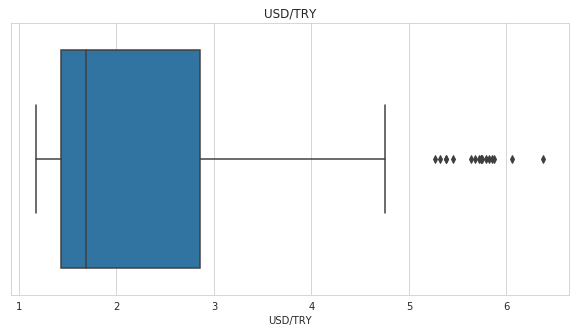

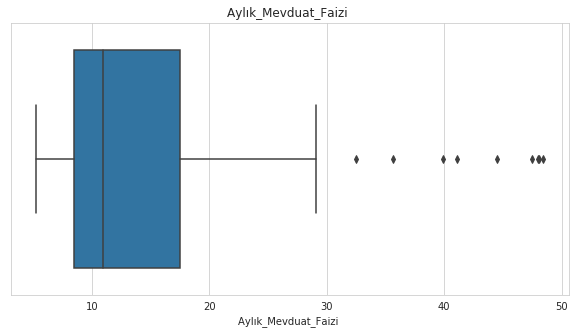

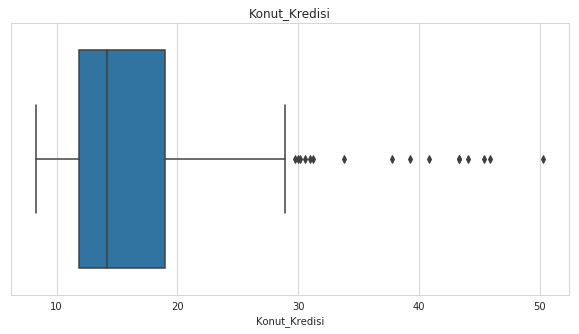

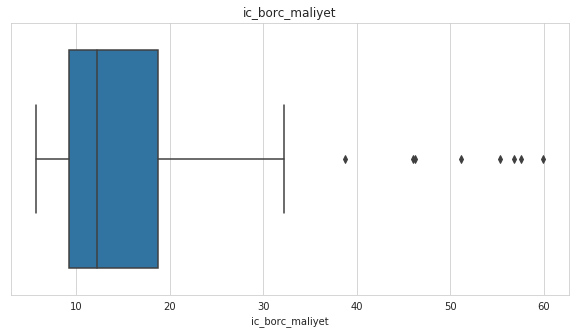

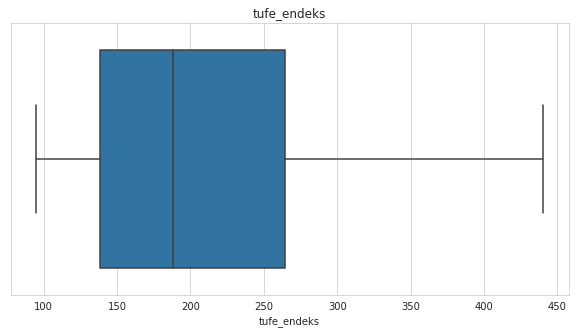

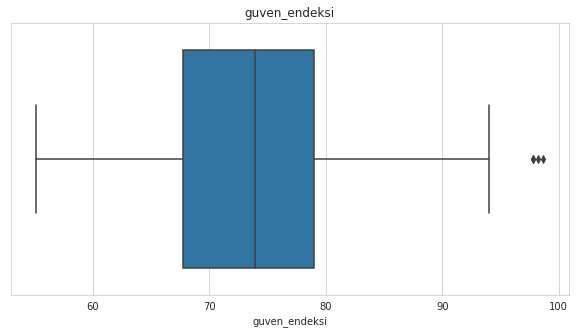

In [16]:
for col in cols_list:
    plt.figure(figsize=(10, 5))
    # Create the boxplot
    ax = sns.boxplot(x=col, data=df_train)
    # Set the `xlim`
    #ax.set(xlim=(0, 100))
    # Add title
    ax.set_title(col)
    # Show the plot
    plt.show()

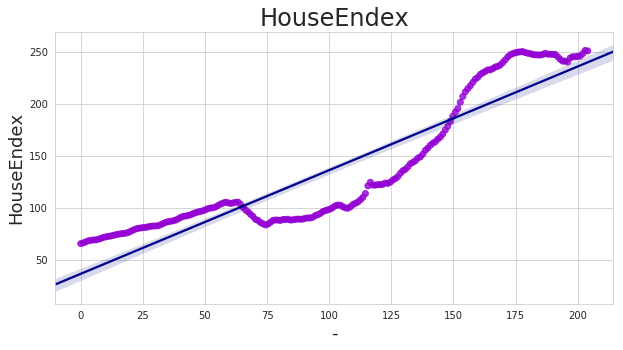

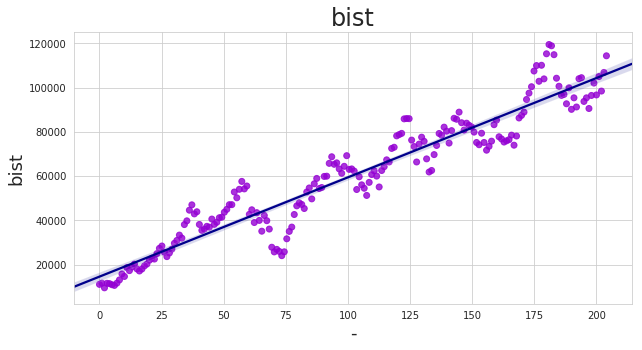

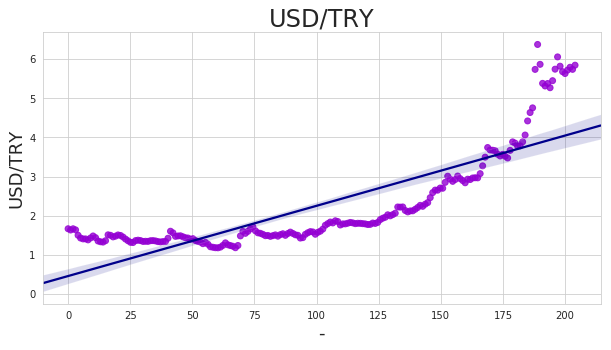

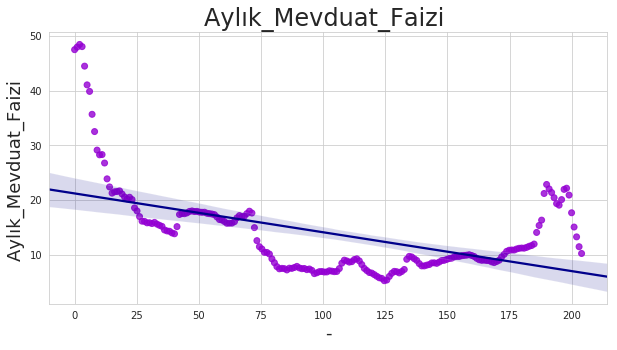

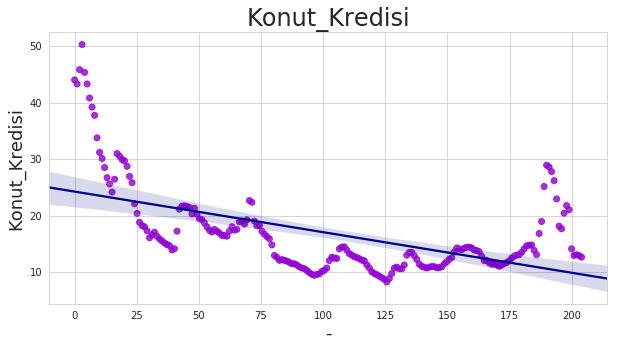

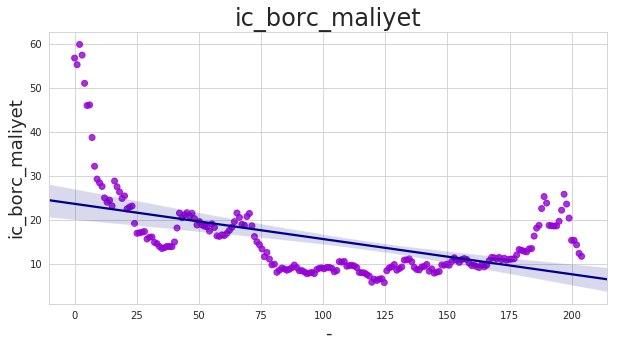

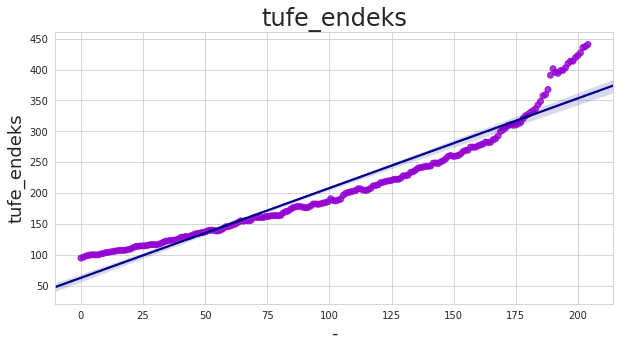

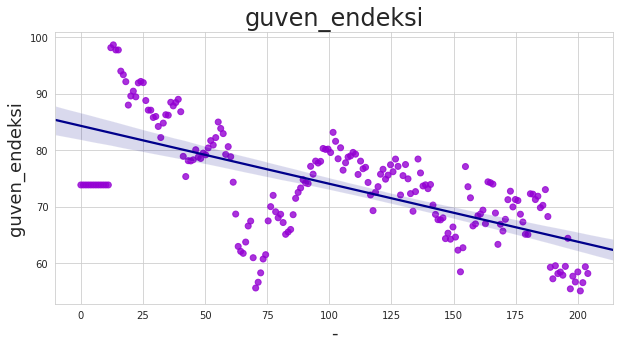

In [17]:
for col in cols_list:    
    y_axis = col
    count = df_train[y_axis].count()
    value=df_train[y_axis]

    plt.figure(figsize=(10, 5))
    sns.regplot(np.linspace(0, count, count), df_train[y_axis], fit_reg=True,
                scatter_kws={'facecolors':np.where( value==True , "red", 'darkviolet'),
               'edgecolor':np.where(value==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkblue'})
    plt.title(col, fontsize=24)
    plt.xlabel('-', fontsize=18)
    plt.ylabel(col, fontsize=18)
    # plt.savefig('figures/Standardised_SalePrice_GrLivArea.png')


# HouseEndex vs other

- Kirmizi: bubble fiyatlari iceren regresyon cizgi
- Mavi: bubble fiyatlari iceren regresyon cizgi

mavi ve kirmizi cizgi arasinda buyuk bir fark varsa, bubble/anomaly mi demek?

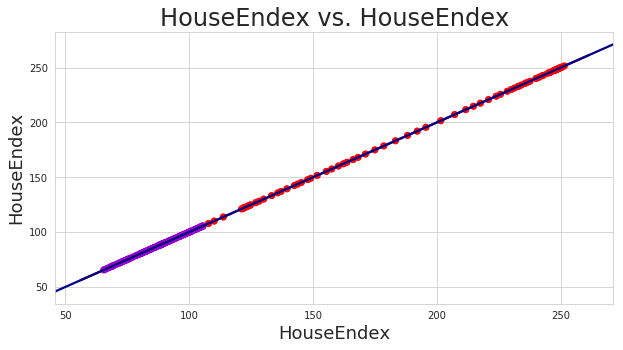

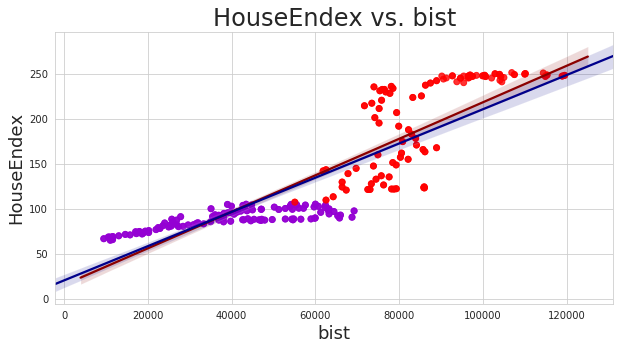

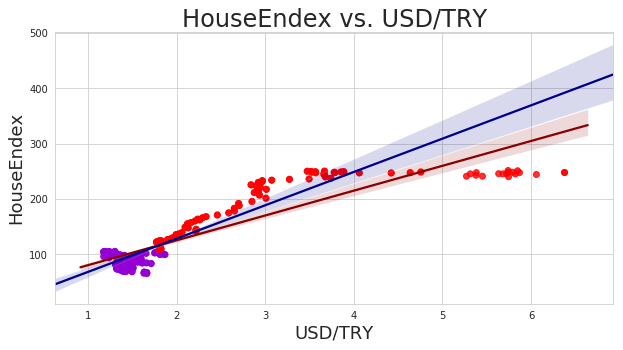

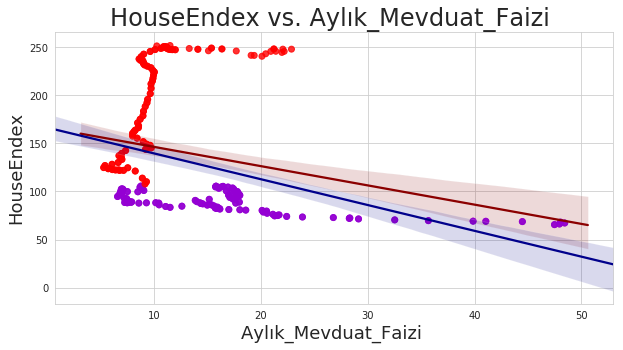

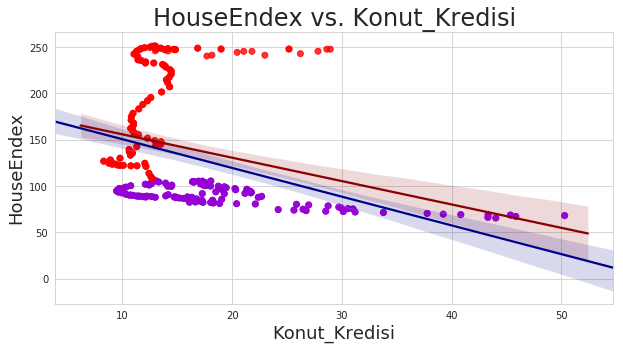

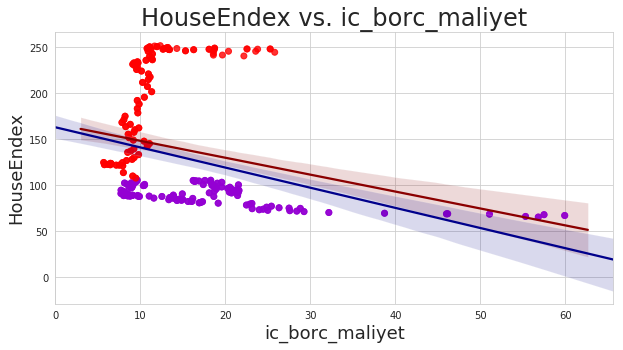

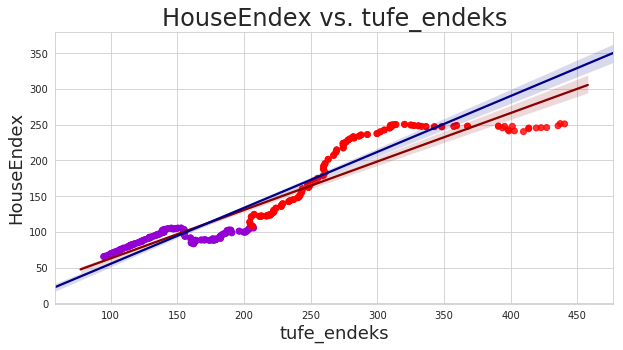

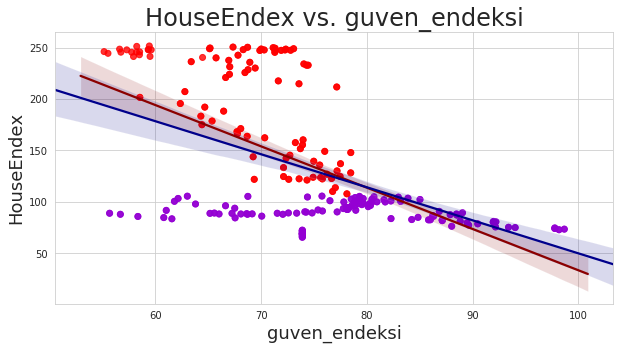

In [18]:
# Displays A Scatter Plot with Regression Line + Outliers in Red

for col in cols_list:
    x_axis = col
    y_axis = 'HouseEndex'
    value=(df_train[y_axis] > 107)
    value2=(df_train[y_axis][:-15] > 107)

    plt.figure(figsize=(10, 5))
    sns.regplot(df_train[x_axis], df_train[y_axis], fit_reg=True,
                scatter_kws={'facecolors':np.where( value==True , "red", 'darkviolet'),
               'edgecolor':np.where(value==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkred'})
    
    sns.regplot(df_train[x_axis][:-15], df_train[y_axis][:-15], fit_reg=True,
                scatter_kws={'facecolors':np.where( value2==True , "red", 'darkviolet'),
               'edgecolor':np.where(value2==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkblue'})
    
    plt.title('HouseEndex vs. {}'.format(x_axis), fontsize=24)
    plt.xlabel(x_axis, fontsize=18)
    plt.ylabel('HouseEndex', fontsize=18)
    # plt.savefig('figures/Standardised_SalePrice_GrLivArea.png')


# XGBoost

hiç faydası yok bu konuda, eğitimde kullandığımız verileri göre sonuç veriyor, ama şişik olup olmadığını gösteremez

In [19]:
#y_full = df_train['HouseEndex']
#X_full = df_train.drop(columns=["HouseEndex"])

y_full = df_train['HouseEndex'][:-15]
X_full = df_train.drop(columns=["HouseEndex"])[:-15]

y_test = df_train['HouseEndex'][-15:]
X_test = df_train.drop(columns=["HouseEndex"])[-15:]

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=123)

In [20]:
# final model with tuned parameters
model = XGBRegressor(max_depth=6, #dflt 6
                     learning_rate=0.1, #dflt 100
                     n_estimators=1000, #dflt 0.1
                     verbosity = 3,
                     objective='reg:linear',
                     n_jobs=-1,
                     gamma=0, #dflt: 0
                     min_child_weight=3, #0 dflt: 1
                     subsample=0.5,
                     colsample_bytree=1,
                     reg_lambda=0.99994, #dflt: 1
                     reg_alpha=0.00003, #dflt: 0
                     tree_method='exact',
                     scale_pos_weight=1, # dflt: 1
                     random_state=123)

In [21]:
tick=time.time()

fitted_model = model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         eval_metric='rmse', # Equivalent to RMSLE since we have log1p(SalePrice)
                         early_stopping_rounds=1000,
                         verbose=True)

print("Duration: {}s".format(time.time()-tick))

[14:30:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-rmse:132.266
Will train until validation_0-rmse hasn't improved in 1000 rounds.
[14:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-rmse:119.446
[14:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-rmse:107.557
[14:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/

/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[18]	validation_0-rmse:21.5543
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[19]	validation_0-rmse:19.4625
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[20]	validation_0-rmse:17.5684
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[21]	validation_0-rmse:16.017
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruni

[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[56]	validation_0-rmse:4.88158
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[57]	validation_0-rmse:4.89351
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[58]	validation_0-rmse:4.9047
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[59]	validation_0-rmse:4.91329
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pru

[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[94]	validation_0-rmse:4.70482
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[95]	validation_0-rmse:4.71148
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[96]	validation_0-rmse:4.72635
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[97]	validation_0-rmse:4.73318
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[131]	validation_0-rmse:4.63343
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[132]	validation_0-rmse:4.6306
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[133]	validation_0-rmse:4.62795
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[134]	validation_0-rmse:4.62081
[14:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[169]	validation_0-rmse:4.55119
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[170]	validation_0-rmse:4.55066
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[171]	validation_0-rmse:4.54383
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[172]	validation_0-rmse:4.54673
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[207]	validation_0-rmse:4.51014
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[208]	validation_0-rmse:4.51144
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[209]	validation_0-rmse:4.5129
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[210]	validation_0-rmse:4.51146
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[244]	validation_0-rmse:4.50214
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[245]	validation_0-rmse:4.50188
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[246]	validation_0-rmse:4.50217
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[247]	validation_0-rmse:4.50314
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[282]	validation_0-rmse:4.50733
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[283]	validation_0-rmse:4.50713
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[284]	validation_0-rmse:4.5071
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[285]	validation_0-rmse:4.50783
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[319]	validation_0-rmse:4.50369
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[320]	validation_0-rmse:4.50458
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[321]	validation_0-rmse:4.50367
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[322]	validation_0-rmse:4.50362
[14:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[357]	validation_0-rmse:4.49878
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[358]	validation_0-rmse:4.49879
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[359]	validation_0-rmse:4.49824
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[360]	validation_0-rmse:4.49838
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[395]	validation_0-rmse:4.49689
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[396]	validation_0-rmse:4.49658
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[397]	validation_0-rmse:4.49685
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[398]	validation_0-rmse:4.49698
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[433]	validation_0-rmse:4.49519
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[434]	validation_0-rmse:4.49525
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[435]	validation_0-rmse:4.49533
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[436]	validation_0-rmse:4.49543
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[471]	validation_0-rmse:4.49448
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[472]	validation_0-rmse:4.49436
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[473]	validation_0-rmse:4.49434
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[474]	validation_0-rmse:4.49425
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[509]	validation_0-rmse:4.4934
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[510]	validation_0-rmse:4.49338
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[511]	validation_0-rmse:4.49339
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[512]	validation_0-rmse:4.49327
[14:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[547]	validation_0-rmse:4.49313
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[548]	validation_0-rmse:4.49303
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[549]	validation_0-rmse:4.49302
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[550]	validation_0-rmse:4.493
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree 

[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[584]	validation_0-rmse:4.49234
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[585]	validation_0-rmse:4.49237
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[586]	validation_0-rmse:4.49239
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[587]	validation_0-rmse:4.49243
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[622]	validation_0-rmse:4.49198
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[623]	validation_0-rmse:4.49197
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[624]	validation_0-rmse:4.49201
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[625]	validation_0-rmse:4.492
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree 

[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[659]	validation_0-rmse:4.49205
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[660]	validation_0-rmse:4.49201
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[661]	validation_0-rmse:4.49202
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[662]	validation_0-rmse:4.49202
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[696]	validation_0-rmse:4.49201
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[697]	validation_0-rmse:4.492
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[698]	validation_0-rmse:4.49199
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[699]	validation_0-rmse:4.49198
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree 

[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[734]	validation_0-rmse:4.49198
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[735]	validation_0-rmse:4.49198
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[736]	validation_0-rmse:4.49196
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[737]	validation_0-rmse:4.49192
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[772]	validation_0-rmse:4.49198
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[773]	validation_0-rmse:4.49197
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[774]	validation_0-rmse:4.49198
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[775]	validation_0-rmse:4.49198
[14:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[810]	validation_0-rmse:4.49184
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[811]	validation_0-rmse:4.49184
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[812]	validation_0-rmse:4.49185
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[813]	validation_0-rmse:4.49185
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[847]	validation_0-rmse:4.49185
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[848]	validation_0-rmse:4.49184
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[849]	validation_0-rmse:4.49183
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[850]	validation_0-rmse:4.49182
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[884]	validation_0-rmse:4.49184
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[885]	validation_0-rmse:4.49184
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[886]	validation_0-rmse:4.49184
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[887]	validation_0-rmse:4.49184
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[921]	validation_0-rmse:4.49179
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[922]	validation_0-rmse:4.49179
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[923]	validation_0-rmse:4.49179
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[924]	validation_0-rmse:4.49179
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[925]	validation_0-rmse:4.4918
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/t

[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[960]	validation_0-rmse:4.4918
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[961]	validation_0-rmse:4.4918
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[962]	validation_0-rmse:4.4918
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[963]	validation_0-rmse:4.4918
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree prun

[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[998]	validation_0-rmse:4.49178
[14:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[999]	validation_0-rmse:4.49178
Duration: 5.0471954345703125s


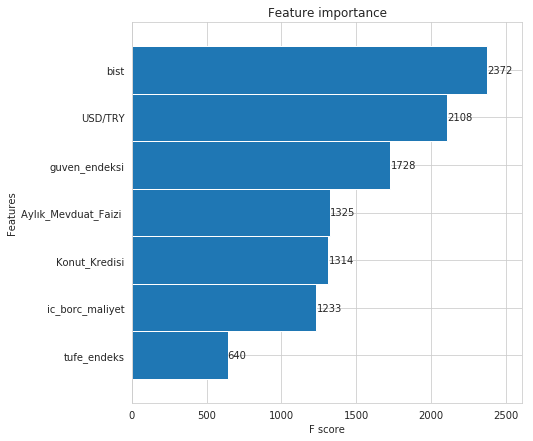

In [22]:
# Plot feature importance
figsize=(7,7)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)


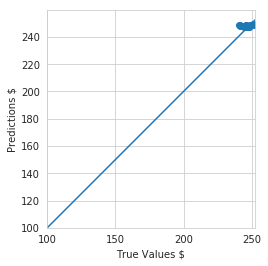

In [23]:
# predict sales in test dataset
test_predictions = model.predict(X_test).flatten()

# scatter plot of True vs Predicted values
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,plt.xlim()[1]])
plt.ylim([100,plt.ylim()[1]])
_ = plt.plot([0, 1000], [0, 1000])

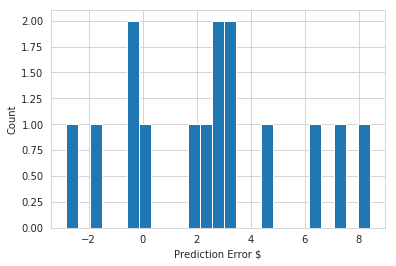

In [24]:
# Histogram of error values
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $")
_ = plt.ylabel("Count")

# Anomaly detection approach

Loss > Threshold ise = anomaly > bubble mi demek?

In [25]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(df_train[:-15]) # Healthy/normal data
X_test = scaler.fit_transform(df_train[-15:]) # Unhealthy/anomaly data

In [26]:
X_train.shape

(189, 8)

In [27]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [28]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [29]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time

In [30]:
history = model.fit(X_train, X_train, epochs=100, batch_size=10,
                    validation_split=0.05).history

Train on 179 samples, validate on 10 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
179/179 [==============================] - 6s 32ms/sample - loss: 0.2658 - val_loss: 0.5141
Epoch 2/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.2476 - val_loss: 0.4942
Epoch 3/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.2313 - val_loss: 0.4739
Epoch 4/100
179/179 [==============================] - 1s 3ms/sample - loss: 0.2179 - val_loss: 0.4544
Epoch 5/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.2076 - val_loss: 0.4362
Epoch 6/100
179/179 [==============================] - 0s 1ms/sample - loss: 0.1996 - val_loss: 0.4212
Epoch 7/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.1931 - val_loss: 0.4078
Epoch 8/100
179/179 [==============================] - 0s 1ms/sample - loss: 0.1872 - val_loss: 0.3922
Epoch 9/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.181

179/179 [==============================] - 0s 2ms/sample - loss: 0.0426 - val_loss: 0.1012
Epoch 77/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.0421 - val_loss: 0.1004
Epoch 78/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.0421 - val_loss: 0.1005
Epoch 79/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.0419 - val_loss: 0.1018
Epoch 80/100
179/179 [==============================] - 0s 1ms/sample - loss: 0.0418 - val_loss: 0.0985
Epoch 81/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.0416 - val_loss: 0.1019
Epoch 82/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.0418 - val_loss: 0.1032
Epoch 83/100
179/179 [==============================] - 0s 2ms/sample - loss: 0.0417 - val_loss: 0.0999
Epoch 84/100
179/179 [==============================] - 0s 1ms/sample - loss: 0.0414 - val_loss: 0.0993
Epoch 85/100
179/179 [==============================] - 0s 1ms/sample - loss:

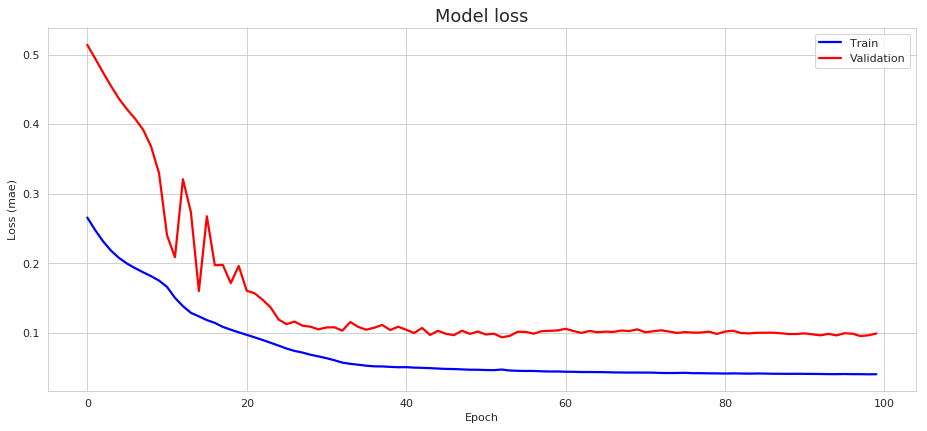

In [31]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

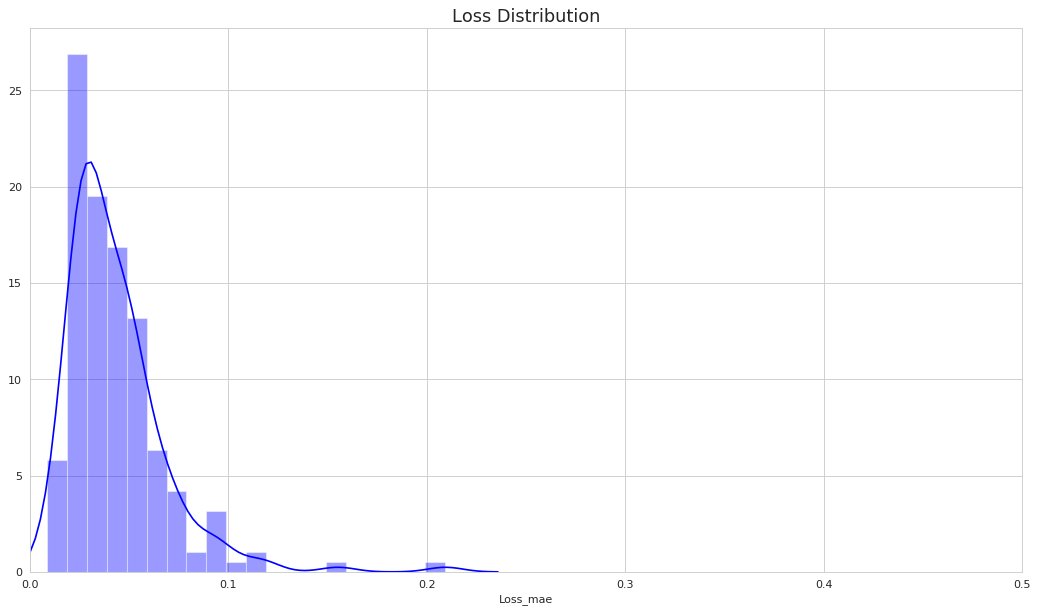

In [32]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[:-15].index

scored = pd.DataFrame(index=df_train[:-15].index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

#Out[17]:
#(0.0, 0.5)

In [33]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[-15:].index

scored = pd.DataFrame(index=df_train[-15:].index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.2
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Tarih,,,
2018-10,0.232540,0.2,True
2018-11,0.184396,0.2,False
2018-12,0.136858,0.2,False
2019-01,0.174522,0.2,False
2019-02,0.140638,0.2,False


In [34]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train[:-15].columns)
X_pred_train.index = df_train[:-15].index

scored_train = pd.DataFrame(index=df_train[:-15].index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.2
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored
scored.to_csv("/home/ipcvlab/Desktop/output.csv")

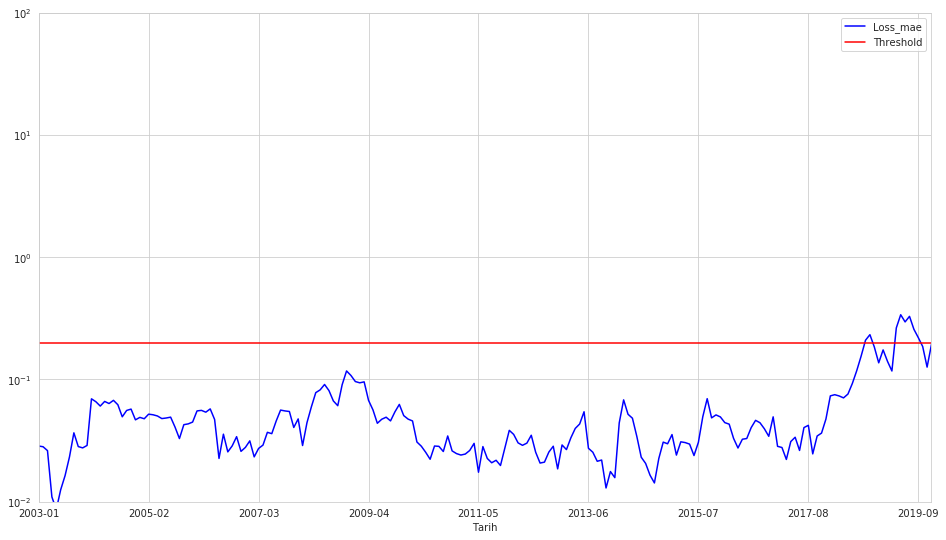

In [35]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])